In [2]:
from data_preprocessing import decompress_pickle, compressed_pickle
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import preprocessing
import os

In [17]:
df = decompress_pickle("../data/preprocessed/BikeRental_complete.pbz2")

# overview

In [17]:
profile = ProfileReport(df, title="data overview", explorative = True)
profile

# outliers

<AxesSubplot:>

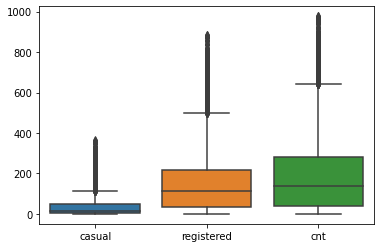

In [10]:
col_boxplot_count =  ["casual", "registered", "cnt"]
sns.boxplot(data=df[col_boxplot_count])

### most likely, these count outliers did not arise from any type of error, but are "natural" novelties of the data

<AxesSubplot:>

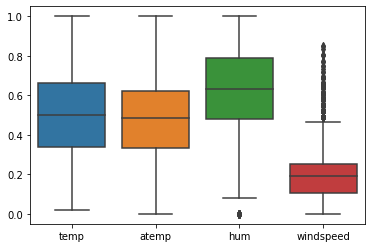

In [16]:
col_boxplot = ['temp', 'atemp', 'hum', 'windspeed']
sns.boxplot(data=df[col_boxplot])

### humidity and windspeed show significant outliers, so we should take a closer look if these can be instrument errors ...

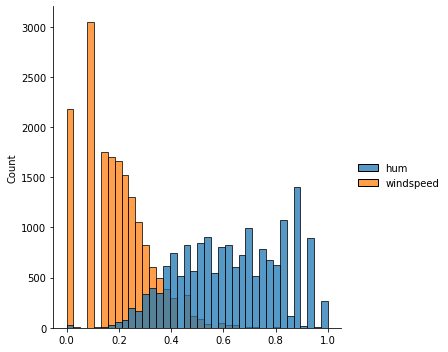

In [30]:
outliers_col = ['hum', 'windspeed']
sns.displot(df[outliers_col])


### windspeed has high frequency around 0 which highly affects the mean and IQR

<AxesSubplot:xlabel='season', ylabel='hum'>

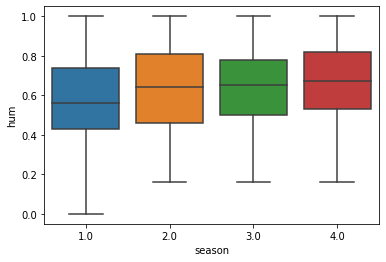

In [28]:
sns.boxplot(x=df["season"], y=df["hum"])

### winter air: cold winter air contains less water, so the humidity is lower.
### -> no outlier imputation needed

<AxesSubplot:xlabel='season', ylabel='windspeed'>

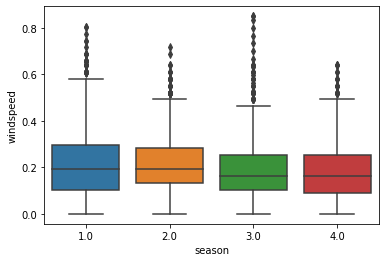

In [29]:
sns.boxplot(x=df["season"], y=df["windspeed"])

### difficult to apply domain knowledge since data has already bin normalized

### take a closer look at windspeed ...

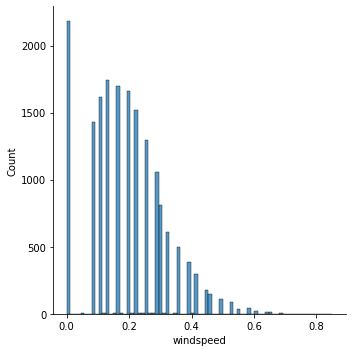

In [31]:
sns.displot(df["windspeed"])


### excluding the 0 values, the distribution resembles the log-normal distribution

### the frequent occurence of windspeed 0 might be due to an instrument measurement threshold (explaining the gap betwen 0.0 and 0.1)

### we can conclude that the windspeed 0 values correspond to low windspeeds

### -> result: no imputation of outliers (e.g. via mean) needed

# normalization

## feature overview

In [29]:
df.min()

datetime      2011-01-01 00:00:00
dteday                 2011-01-01
season                          1
yr                              0
mnth                            1
hr                              0
holiday                         0
weekday                         0
workingday                      0
weathersit                      1
temp                         0.02
atemp                           0
hum                             0
windspeed                       0
casual                          0
registered                      0
cnt                             1
dtype: object

In [30]:
df.max()

datetime      2012-12-31 23:00:00
dteday                 2012-12-31
season                          4
yr                              1
mnth                           12
hr                             23
holiday                         1
weekday                         6
workingday                      1
weathersit                      4
temp                            1
atemp                           1
hum                             1
windspeed                  0.8507
casual                        367
registered                    886
cnt                           977
dtype: object

### we can see that temp has not been normalized correctly (minimum of 0.02 and maximimum of 1)
### we can see that windspeed has not been normalized correctly (minimum of 0 and maximum of 0.8507)

## normalization of non-normalized continous variables

In [38]:
cont_var = ["temp", "windspeed", "casual","registered","cnt"]

In [34]:
# deep copy data set:
df_norm = df.copy(deep=True)


In [73]:
# store true min and max for count variables in order to revert normalization later
count_variables = ["casual","registered","cnt"]
max_count = pd.DataFrame(df[count_variables].max())
min_count = pd.DataFrame(df[count_variables].min())
max_min_count = pd.concat([max_count, min_count], axis=1)
max_min_count.columns = ["max", "min"]


In [74]:
max_min_count

max  min
casual      367.0  0.0
registered  886.0  0.0
cnt         977.0  1.0

In [39]:
# apply MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
df_norm[cont_var] = mm_scaler.fit_transform(df_norm[cont_var])


In [40]:
df_norm.min()

datetime      2011-01-01 00:00:00
dteday                 2011-01-01
season                          1
yr                              0
mnth                            1
hr                              0
holiday                         0
weekday                         0
workingday                      0
weathersit                      1
temp                            0
atemp                           0
hum                             0
windspeed                       0
casual                          0
registered                      0
cnt                             0
dtype: object

In [41]:
df_norm.max()

datetime      2012-12-31 23:00:00
dteday                 2012-12-31
season                          4
yr                              1
mnth                           12
hr                             23
holiday                         1
weekday                         6
workingday                      1
weathersit                      4
temp                            1
atemp                           1
hum                             1
windspeed                       1
casual                          1
registered                      1
cnt                             1
dtype: object

# creating dummy variables

### dummy variables need to be created for categorical features

In [212]:
# deep copy data set:
df_preproc = df_norm.copy(deep=True)




In [213]:
# change data type of weathersit to np.uint8 in order to prevent false creation of dummies
df_preproc.weathersit = df_preproc.weathersit.astype(int)

In [214]:
df_preproc["weathersit"].dtypes

dtype('int64')

In [215]:
dummy_var = ["season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]

for v in dummy_var:
    dummies = pd.get_dummies(df_preproc[v], prefix=v, drop_first=False)
    df_preproc = pd.concat([df_preproc, dummies], axis=1)


In [216]:
df_preproc

datetime      dteday  season   yr  mnth  hr  holiday  \
0     2011-01-01 00:00:00  2011-01-01     1.0  0.0     1   0      0.0   
1     2011-01-01 01:00:00  2011-01-01     1.0  0.0     1   1      0.0   
2     2011-01-01 02:00:00  2011-01-01     1.0  0.0     1   2      0.0   
3     2011-01-01 03:00:00  2011-01-01     1.0  0.0     1   3      0.0   
4     2011-01-01 04:00:00  2011-01-01     1.0  0.0     1   4      0.0   
...                   ...         ...     ...  ...   ...  ..      ...   
17539 2012-12-31 19:00:00  2012-12-31     1.0  1.0    12  19      0.0   
17540 2012-12-31 20:00:00  2012-12-31     1.0  1.0    12  20      0.0   
17541 2012-12-31 21:00:00  2012-12-31     1.0  1.0    12  21      0.0   
17542 2012-12-31 22:00:00  2012-12-31     1.0  1.0    12  22      0.0   
17543 2012-12-31 23:00:00  2012-12-31     1.0  1.0    12  23      0.0   

       weekday  workingday  weathersit  ...  weekday_3  weekday_4  weekday_5  \
0            5         0.0           1  ...          0          0          1   
1            5         0.0           1  ...          0          0          1   
2            5         0.0           1  ...          0          0          1   
3            5         0.0           1  ...          0          0          1   
4            5         0.0           1  ...          0          0          1   
...        ...         ...         ...  ...        ...        ...        ...   
17539        0         1.0           2  ...          0          0          0   
17540        0         1.0           2  ...          0          0          0   
17541        0         1.0           1  ...          0          0          0   
17542        0         1.0           1  ...          0          0          0   
17543        0         1.0           1  ...          0          0          0   

       weekday_6  workingday_0.0  workingday_1.0  weathersit_1  weathersit_2  \
0              0               1               0             1             0   
1              0               1               0             1             0   
2              0               1               0             1             0   
3              0               1               0             1             0   
4              0               1               0             1             0   
...          ...             ...             ...           ...           ...   
17539          0               0               1             0             1   
17540          0               0               1             0             1   
17541          0               0               1             1             0   
17542          0               0               1             1             0   
17543          0               0               1             1             0   

       weathersit_3  weathersit_4  
0                 0             0  
1                 0             0  
2                 0             0  
3                 0             0  
4                 0             0  
...             ...           ...  
17539             0             0  
17540             0             0  
17541             0             0  
17542             0             0  
17543             0             0  

[17544 rows x 74 columns]

In [217]:
for col in df_preproc.columns:
    print(col)

datetime
dteday
season
yr
mnth
hr
holiday
weekday
workingday
weathersit
temp
atemp
hum
windspeed
casual
registered
cnt
season_1.0
season_2.0
season_3.0
season_4.0
yr_0.0
yr_1.0
mnth_1
mnth_2
mnth_3
mnth_4
mnth_5
mnth_6
mnth_7
mnth_8
mnth_9
mnth_10
mnth_11
mnth_12
hr_0
hr_1
hr_2
hr_3
hr_4
hr_5
hr_6
hr_7
hr_8
hr_9
hr_10
hr_11
hr_12
hr_13
hr_14
hr_15
hr_16
hr_17
hr_18
hr_19
hr_20
hr_21
hr_22
hr_23
holiday_0.0
holiday_1.0
weekday_0
weekday_1
weekday_2
weekday_3
weekday_4
weekday_5
weekday_6
workingday_0.0
workingday_1.0
weathersit_1
weathersit_2
weathersit_3
weathersit_4


### remove unneccesary (transformed) features

In [218]:
dummy_var

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

In [3]:
df_preproc.drop(dummy_var, axis=1)

NameError: name 'df_preproc' is not defined

In [2]:
# drop leakage variables 
leak_var = ["casual", "registered"]
df_preproc = df_preproc.drop(leak_var, axis=1)

NameError: name 'df_preproc' is not defined